In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, precision_recall_fscore_support, 
    confusion_matrix, precision_recall_curve, f1_score, precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from uszipcode import SearchEngine

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [3]:
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 1000)

In [4]:
df = pd.read_csv('house_prices_data.csv')

In [5]:
df.head()

id             date   price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900         3       1.00         1180   
1  6414100192  20141209T000000  538000         3       2.25         2570   
2  5631500400  20150225T000000  180000         2       1.00          770   
3  2487200875  20141209T000000  604000         4       3.00         1960   
4  1954400510  20150218T000000  510000         3       2.00         1680   

   sqft_lot  floors  waterfront  view  condition  premium  sqft_above  \
0      5650     1.0           0     0          3        0        1180   
1      7242     2.0           0     0          3        0        2170   
2     10000     1.0           0     0          3        0         770   
3      5000     1.0           0     0          5        0        1050   
4      8080     1.0           0     0          3        0        1680   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1955             0    98178  47.5112 -122.257   
1            400      1951          1991    98125  47.7210 -122.319   
2              0      1933             0    98028  47.7379 -122.233   
3            910      1965             0    98136  47.5208 -122.393   
4              0      1987             0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503

# EDA, preprocessing and feature engineering

In [6]:
df.set_index('id', inplace=True)

In [7]:
df.shape

(21613, 20)

there are no missing values in the dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21613 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
date             21613 non-null object
price            21613 non-null int64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
premium          21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(4), int64(15), object(1)
memory usage: 3.5+ MB


In [9]:
df.nunique()

date              372
price            4028
bedrooms           13
bathrooms          30
sqft_living      1038
sqft_lot         9782
floors              6
waterfront          2
view                5
condition           5
premium             2
sqft_above        946
sqft_basement     306
yr_built          116
yr_renovated       70
zipcode            70
lat              5034
long              752
sqft_living15     777
sqft_lot15       8689
dtype: int64

In [10]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'premium', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

##### date

In [11]:
df['date'].head()

id
7129300520    20141013T000000
6414100192    20141209T000000
5631500400    20150225T000000
2487200875    20141209T000000
1954400510    20150218T000000
Name: date, dtype: object

In [12]:
# parse date
df['date'] = df['date'].apply(lambda x: x.split('T')[0])

In [13]:
# format date column as datetime type
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [14]:
df['date'].describe()

count                   21613
unique                    372
top       2014-06-23 00:00:00
freq                      142
first     2014-05-02 00:00:00
last      2015-05-27 00:00:00
Name: date, dtype: object

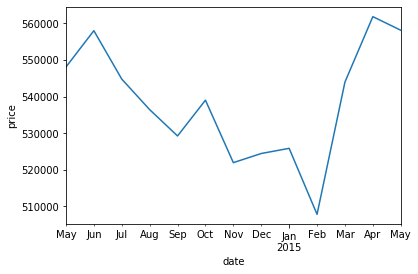

In [15]:
df.groupby(pd.Grouper(key='date', freq='M'))['price'].mean().plot(figsize=(6, 4))
plt.ylabel('price');

Looks like there is kind of relation between month and price

In [16]:
# add columns 'month' and drop column 'date'
df['month'] = df['date'].dt.month

df.drop('date', axis=1, inplace=True)

In [17]:
def plot_dist(col, figsize=(12, 4)):
    ''' 
    Plot:
    1) distribution/count plot of variable with column name specified; 
    2) scatterplot for variable and 'price';
    3) boxplots for 'premium' and varible.
    '''
    fig, ax = plt.subplots(1,3, figsize=figsize)
    if len(df[col].unique()) < 15:
        sns.countplot(df[col], ax = ax[0])
    else:
        sns.distplot(df[col], ax=ax[0])
    sns.scatterplot(df[col], df['price'], ax=ax[1])
    sns.boxplot(df['premium'], df[col], ax=ax[2])
    plt.tight_layout()
    plt.show()
    plt.close()

##### month

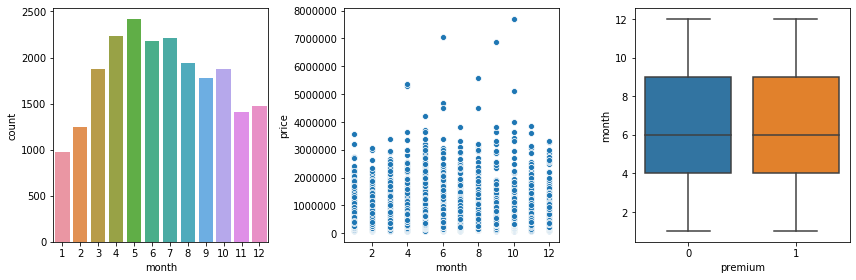

In [18]:
plot_dist('month')

##### price

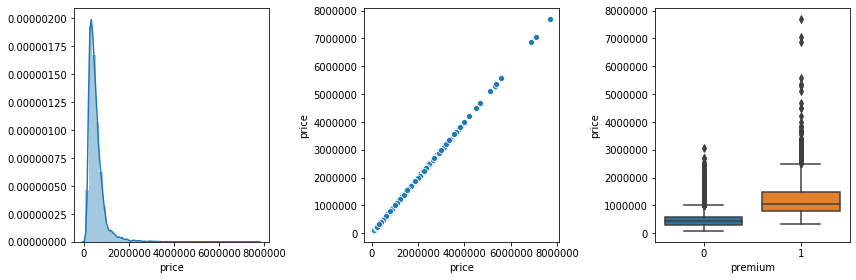

In [19]:
plot_dist('price')

##### bedrooms

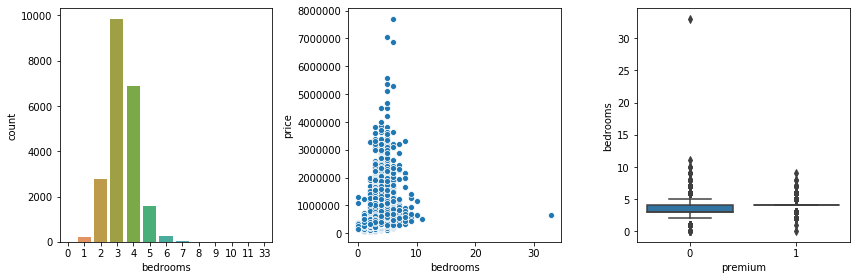

In [20]:
plot_dist('bedrooms')

In [21]:
# there is an outlier
mask_outlier = df['bedrooms']>30
df[mask_outlier]

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id                                                                       
2402100895  640000        33       1.75         1620      6000     1.0   

            waterfront  view  condition  premium  sqft_above  sqft_basement  \
id                                                                            
2402100895           0     0          5        0        1040            580   

            yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
id                                                                             
2402100895      1947             0    98103  47.6878 -122.331           1330   

            sqft_lot15  month  
id                             
2402100895        4700      6

In [22]:
# drop outlier

In [23]:
df.drop(df[mask_outlier].index, inplace=True)

Let's look at the same plots without outliers:

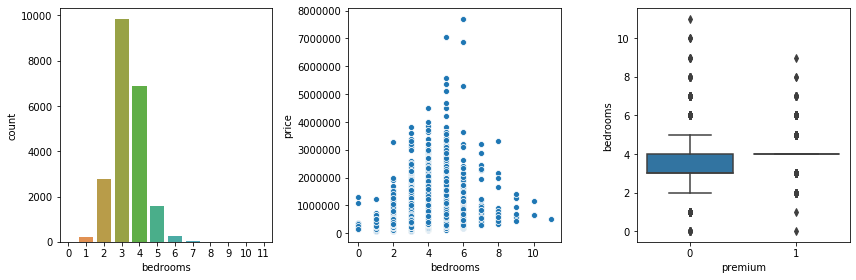

In [24]:
plot_dist('bedrooms')

##### bathrooms

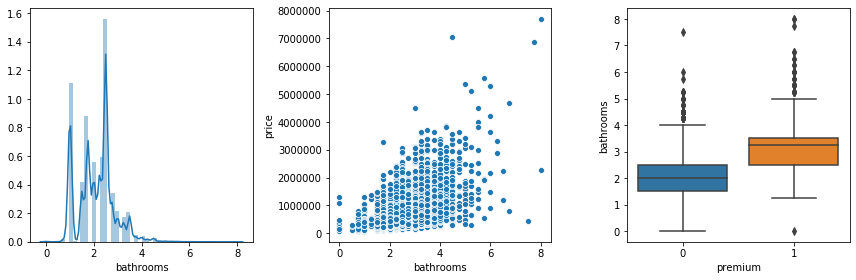

In [25]:
plot_dist('bathrooms')

In [26]:
# create non linear combination of bedrooms and bathrooms
df['bed_bath_rooms'] = df.bedrooms * df.bathrooms

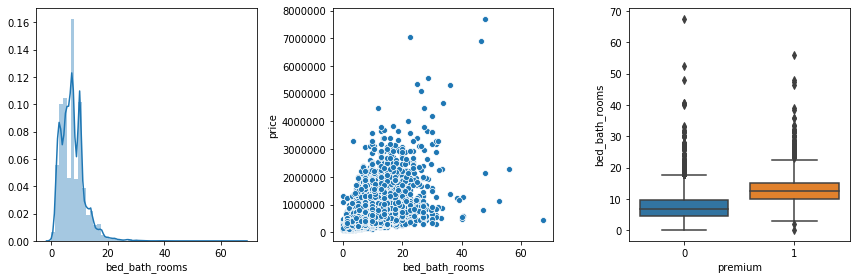

In [27]:
plot_dist('bed_bath_rooms')

##### sqft_living

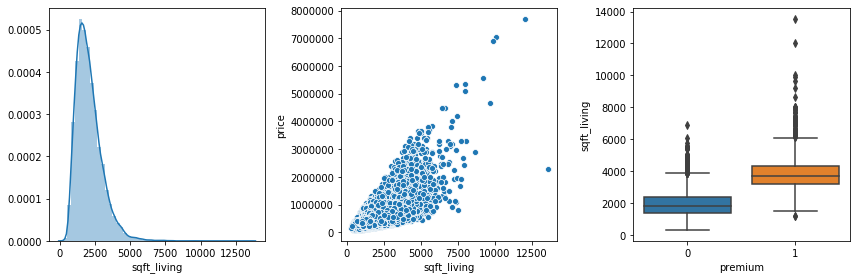

In [28]:
plot_dist('sqft_living')

##### sqft_lot

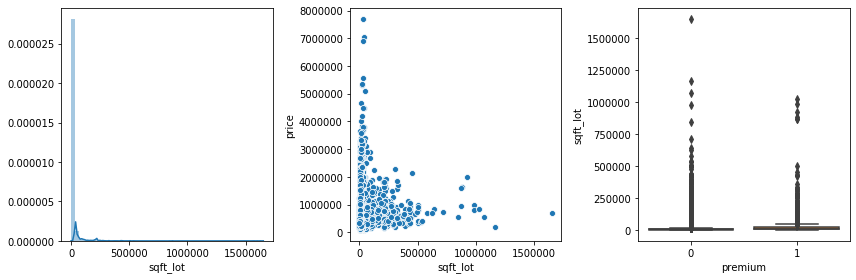

In [29]:
plot_dist('sqft_lot')

##### floors

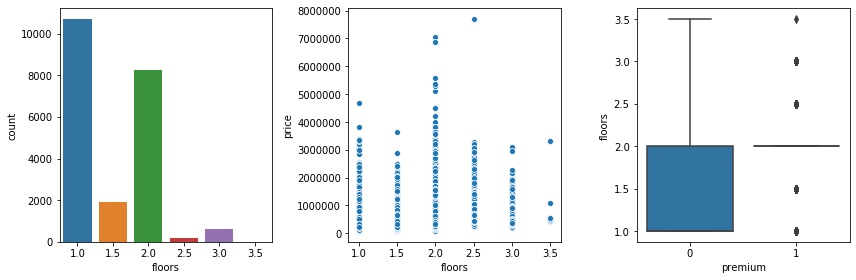

In [30]:
plot_dist('floors')

In [31]:
# there are few houses with number of floors bigger than 2
# if number of floors is bigger than 2 set it to 3 
df['floors'] = np.where(df['floors'] > 2, 3, df['floors'])

In [32]:
df['floors'].value_counts()

1.0    10679
2.0     8241
1.5     1910
3.0      782
Name: floors, dtype: int64

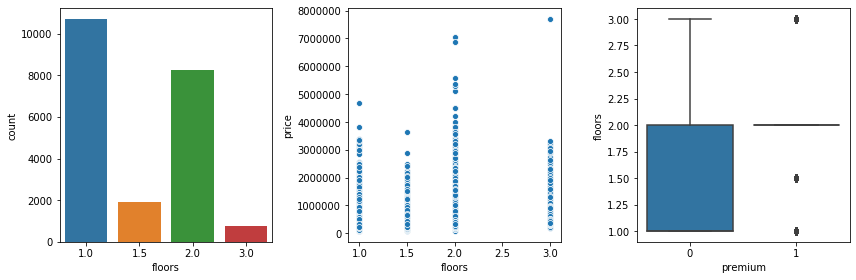

In [33]:
plot_dist('floors')

##### view

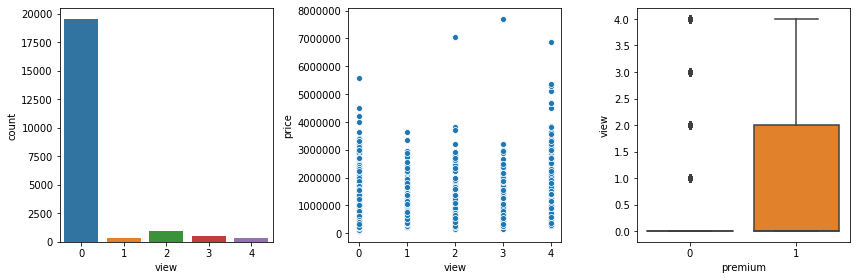

In [34]:
plot_dist('view')

In [35]:
# if view > 0 set it to 1
df['view'] = np.where(df['view'] > 0, 1, 0)

In [36]:
df['view'].value_counts()

0    19488
1     2124
Name: view, dtype: int64

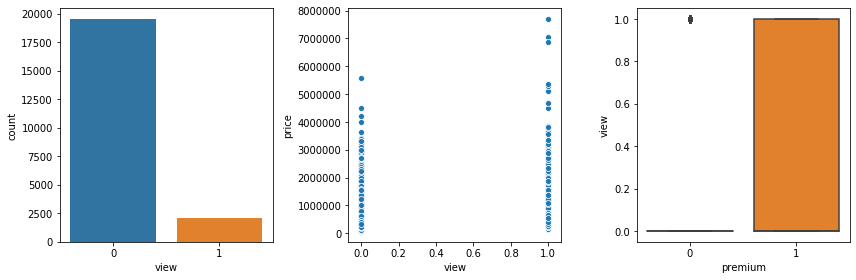

In [37]:
plot_dist('view')

##### condition

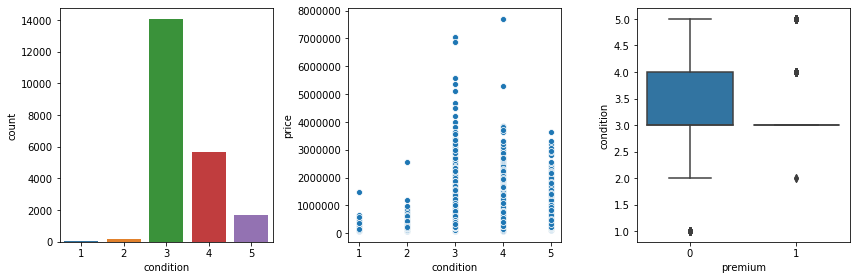

In [38]:
plot_dist('condition')

In [39]:
# there are few houses with condition 1, 2
# join condition 1, 2, 3 and change the numeration
conditions = {
    1: df['condition'] <=3,
    2: df['condition'] == 4,
    3: df['condition'] == 5
}
df['condition'] = np.select(conditions.values(), conditions.keys())

In [40]:
df['condition'].value_counts()

1    14233
2     5679
3     1700
Name: condition, dtype: int64

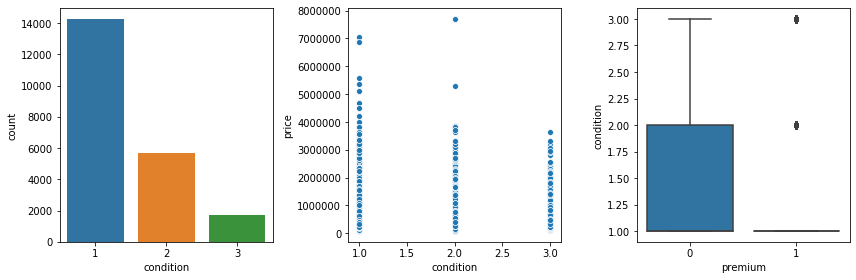

In [41]:
plot_dist('condition')

##### premium

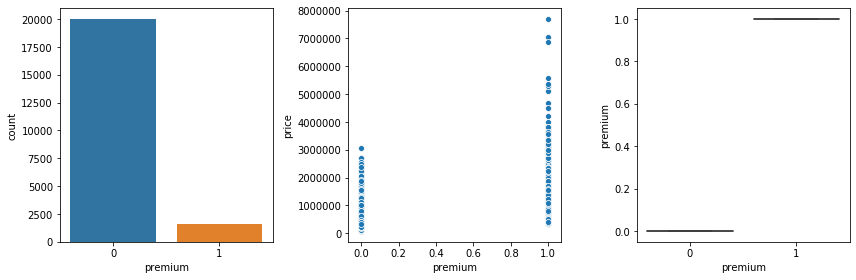

In [42]:
plot_dist('premium')

##### sqft_above

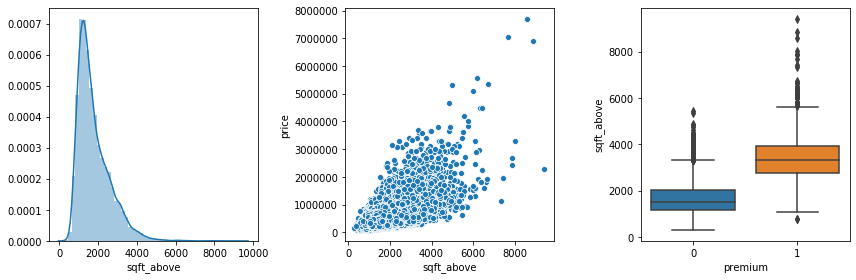

In [43]:
plot_dist('sqft_above')

##### sqft_basement

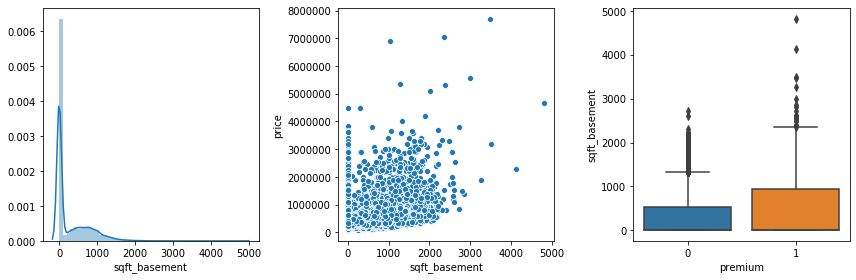

In [44]:
plot_dist('sqft_basement')

In [45]:
# there are a lot of houses without basement (sqft_basement == 0)
# create column has_basement
df['has_basement'] = np.where(df['sqft_basement']>0, 1, 0)
df['has_basement'].value_counts()

0    13126
1     8486
Name: has_basement, dtype: int64

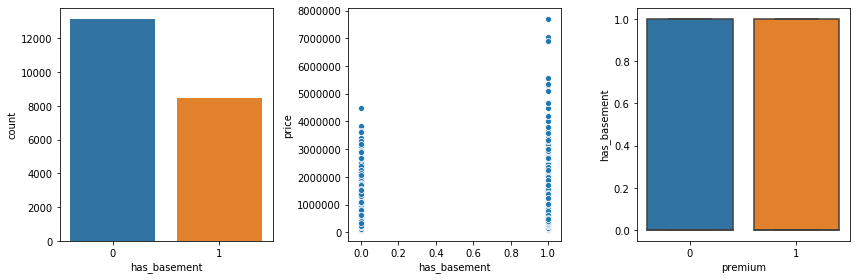

In [46]:
plot_dist('has_basement')

In [47]:
# square of whole house
df['sqft_house'] = df['sqft_living'] + df['sqft_basement'] + df['sqft_above']

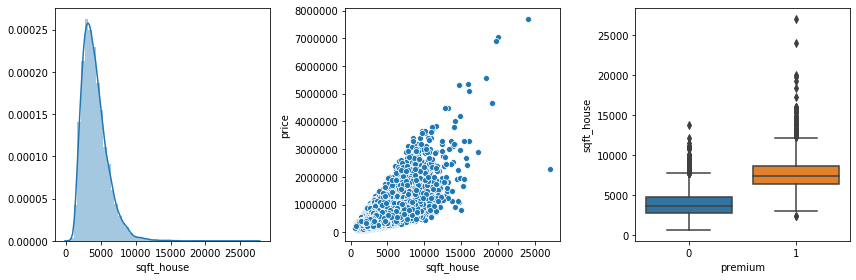

In [48]:
plot_dist('sqft_house')

##### yr_built

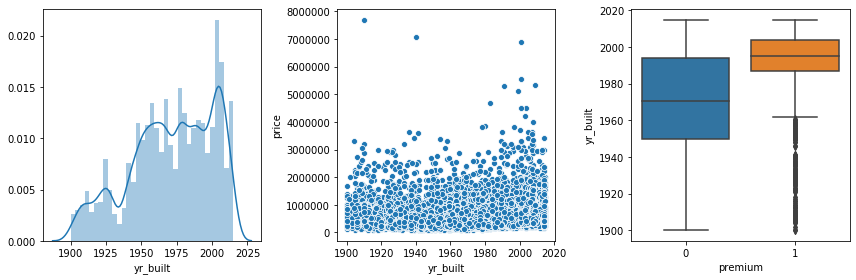

In [49]:
plot_dist('yr_built')

##### yr_renovated

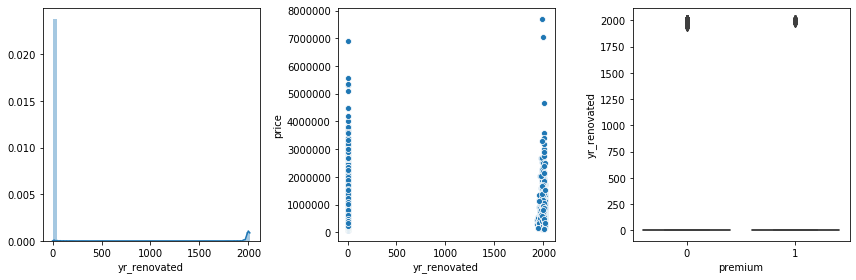

In [50]:
plot_dist('yr_renovated')

Looks like if house was not renovated than yr_renovated set to zero.

In [51]:
# if house was renovated
df['is_renovated']=np.where(df['yr_renovated'] > 0, 1, 0)
df['is_renovated'].value_counts()

0    20698
1      914
Name: is_renovated, dtype: int64

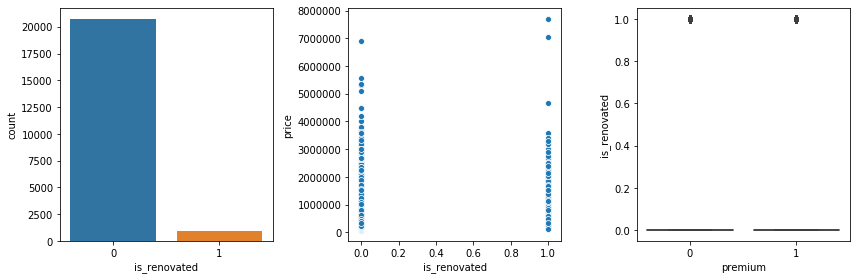

In [52]:
plot_dist('is_renovated')

##### zipcode

In [53]:
df['zipcode'] = df['zipcode'].astype(str)

In [54]:
df['zipcode'].unique()

array(['98178', '98125', '98028', '98136', '98074', '98053', '98003',
       '98198', '98146', '98038', '98007', '98115', '98107', '98126',
       '98019', '98103', '98002', '98133', '98040', '98092', '98030',
       '98119', '98112', '98052', '98027', '98117', '98058', '98001',
       '98056', '98166', '98023', '98070', '98148', '98105', '98042',
       '98008', '98059', '98122', '98144', '98004', '98005', '98034',
       '98075', '98116', '98010', '98118', '98199', '98032', '98045',
       '98102', '98077', '98108', '98168', '98177', '98065', '98029',
       '98006', '98109', '98022', '98033', '98155', '98024', '98011',
       '98031', '98106', '98072', '98188', '98014', '98055', '98039'],
      dtype=object)

Use package unzipcode to pull some additional data for modeling

In [55]:
%%time
search = SearchEngine(simple_zipcode=False)

CPU times: user 6.99 ms, sys: 0 ns, total: 6.99 ms
Wall time: 6.29 ms


In [56]:
df_zipcode = pd.DataFrame()

# specify columns that has useful data for futher modelling
zipcode_cols = [
    'zipcode', 'zipcode_type', 'major_city', 'post_office_city', 
    'county', 'state', 'timezone', 'radius_in_miles',
     'population', 'population_density', 'land_area_in_sqmi',
    'water_area_in_sqmi', 'housing_units', 'occupied_housing_units', 
    'median_home_value', 'median_household_income', 'bounds_west',
    'bounds_east', 'bounds_north', 'bounds_south'
]

# pull data for every zipcode from the original dataset
for zipcode in df['zipcode'].unique():
    zipcode_data = search.by_zipcode(zipcode).to_dict()
    for key in set(zipcode_data.keys()) - set(zipcode_cols):
        del zipcode_data[key]
    df_zipcode = df_zipcode.append(zipcode_data, ignore_index=True)

In [57]:
# drop columns which have single value for the whole dataset
df_zipcode.drop(df_zipcode.nunique()[df_zipcode.nunique() < 2].index, axis=1, inplace=True)

In [58]:
df_zipcode.head()

bounds_east  bounds_north  bounds_south  bounds_west  housing_units  \
0  -122.216608     47.521368     47.474808  -122.283739         9290.0   
1  -122.254136     47.734093     47.697345  -122.330250        18677.0   
2  -122.218452     47.777073     47.731771  -122.276137         8566.0   
3  -122.380334     47.560625     47.512118  -122.409757         7533.0   
4  -121.979225     47.657408     47.599178  -122.098433         8942.0   

   land_area_in_sqmi major_city  median_home_value  median_household_income  \
0               4.85    Seattle           283100.0                  58707.0   
1               5.39    Seattle           372000.0                  53044.0   
2               5.66    Kenmore           386200.0                  82448.0   
3               2.30    Seattle           445700.0                  84344.0   
4              10.68  Sammamish           556000.0                 143686.0   

   occupied_housing_units  population  population_density post_office_city  \
0                  8668.0     24092.0              4966.0      Seattle, WA   
1                 17169.0     37081.0              6879.0      Seattle, WA   
2                  7981.0     20419.0              3606.0      Kenmore, WA   
3                  7069.0     14770.0              6425.0      Seattle, WA   
4                  8626.0     25748.0              2411.0    Sammamish, WA   

   radius_in_miles  water_area_in_sqmi zipcode  
0              3.0                1.02   98178  
1              2.0                1.54   98125  
2              3.0                0.72   98028  
3              4.0                0.84   98136  
4              5.0                1.55   98074

In [59]:
# enrich original dataset with zipcode data
df = df.merge(df_zipcode, on = 'zipcode', how='left')

##### lat

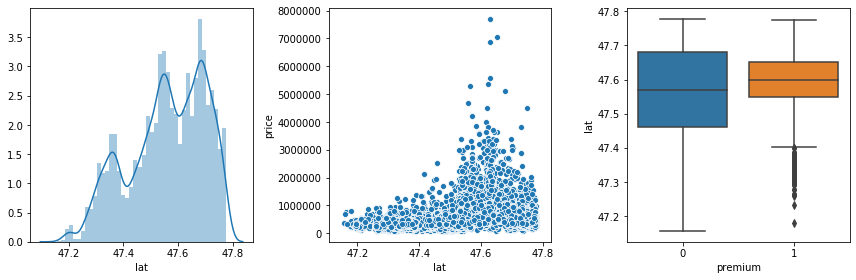

In [60]:
plot_dist('lat')

##### long

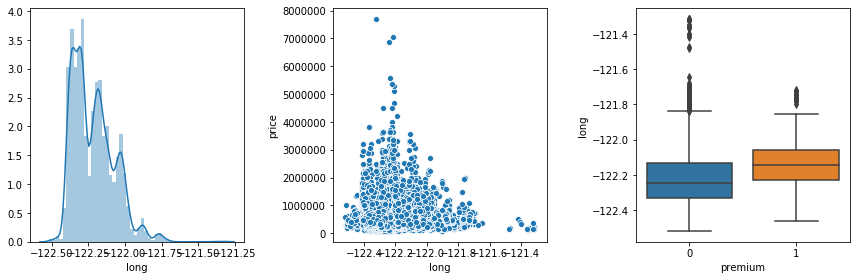

In [61]:
plot_dist('long')

##### sqft_living15

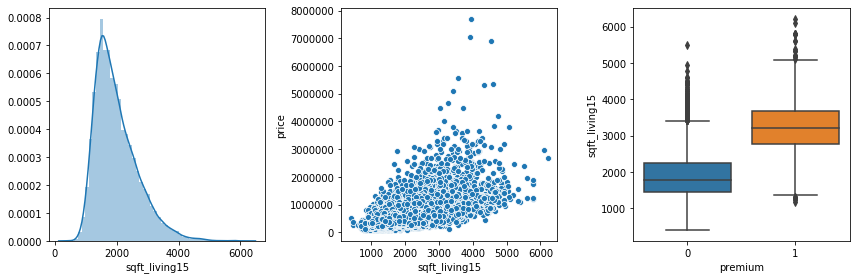

In [62]:
plot_dist('sqft_living15')

In [63]:
# own living square to neighbors living square
df['sqft_living_ratio'] = df['sqft_living']  / df['sqft_living15']

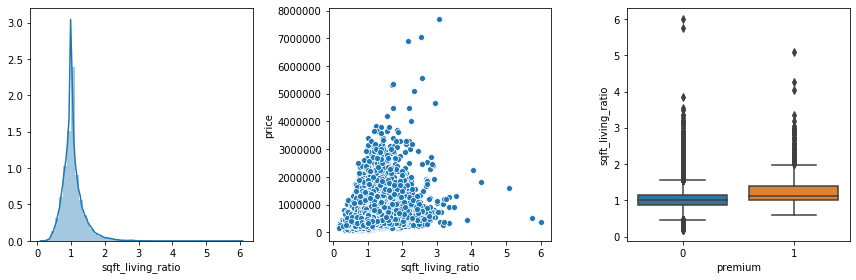

In [64]:
plot_dist('sqft_living_ratio')

##### sqft_lot15

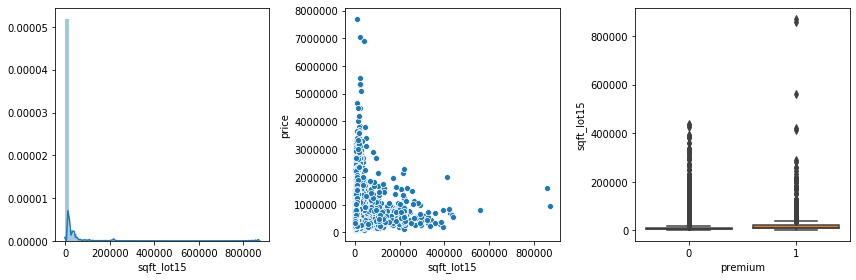

In [65]:
plot_dist('sqft_lot15')

In [66]:
# own lot square to neighbors lot square
df['sqft_lot_ratio'] = df['sqft_lot'] / df['sqft_lot15']

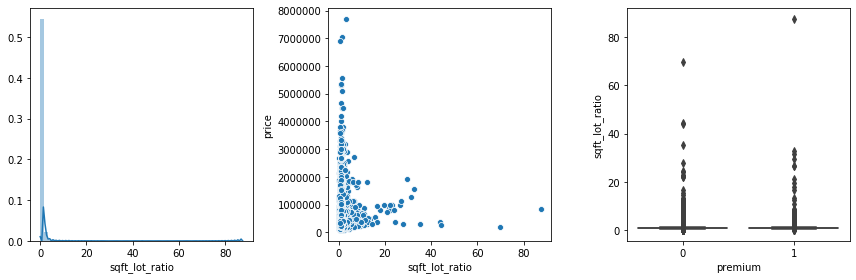

In [67]:
plot_dist('sqft_lot_ratio')

In [68]:
df.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900         3       1.00         1180      5650     1.0           0   
1  538000         3       2.25         2570      7242     2.0           0   
2  180000         2       1.00          770     10000     1.0           0   
3  604000         4       3.00         1960      5000     1.0           0   
4  510000         3       2.00         1680      8080     1.0           0   

   view  condition  premium  sqft_above  sqft_basement  yr_built  \
0     0          1        0        1180              0      1955   
1     0          1        0        2170            400      1951   
2     0          1        0         770              0      1933   
3     0          3        0        1050            910      1965   
4     0          1        0        1680              0      1987   

   yr_renovated zipcode      lat     long  sqft_living15  sqft_lot15  month  \
0             0   98178  47.5112 -122.257           1340        5650     10   
1          1991   98125  47.7210 -122.319           1690        7639     12   
2             0   98028  47.7379 -122.233           2720        8062      2   
3             0   98136  47.5208 -122.393           1360        5000     12   
4             0   98074  47.6168 -122.045           1800        7503      2   

   bed_bath_rooms  has_basement  sqft_house  is_renovated  bounds_east  \
0            3.00             0        2360             0  -122.216608   
1            6.75             1        5140             1  -122.254136   
2            2.00             0        1540             0  -122.218452   
3           12.00             1        3920             0  -122.380334   
4            6.00             0        3360             0  -121.979225   

   bounds_north  bounds_south  bounds_west  housing_units  land_area_in_sqmi  \
0     47.521368     47.474808  -122.283739         9290.0               4.85   
1     47.734093     47.697345  -122.330250        18677.0               5.39   
2     47.777073     47.731771  -122.276137         8566.0               5.66   
3     47.560625     47.512118  -122.409757         7533.0               2.30   
4     47.657408     47.599178  -122.098433         8942.0              10.68   

  major_city  median_home_value  median_household_income  \
0    Seattle           283100.0                  58707.0   
1    Seattle           372000.0                  53044.0   
2    Kenmore           386200.0                  82448.0   
3    Seattle           445700.0                  84344.0   
4  Sammamish           556000.0                 143686.0   

   occupied_housing_units  population  population_density post_office_city  \
0                  8668.0     24092.0              4966.0      Seattle, WA   
1                 17169.0     37081.0              6879.0      Seattle, WA   
2                  7981.0     20419.0              3606.0      Kenmore, WA   
3                  7069.0     14770.0              6425.0      Seattle, WA   
4                  8626.0     25748.0              2411.0    Sammamish, WA   

   radius_in_miles  water_area_in_sqmi  sqft_living_ratio  sqft_lot_ratio  
0              3.0                1.02           0.880597        1.000000  
1              2.0                1.54           1.520710        0.948030  
2              3.0                0.72           0.283088        1.240387  
3              4.0                0.84           1.441176        1.000000  
4              5.0                1.55           0.933333        1.076903

In [69]:
df_corr = df.corr(method='spearman')
fig = go.Figure(data=go.Heatmap(
    z=df_corr,
    x=df_corr.index.tolist(),
    y=df_corr.columns.tolist(),
    colorscale='RdBu', reversescale=True,
    zmin=-1, zmax=1, zauto=False,
    
    
))
fig.update_layout(
    title='Correlogram (Spearman)',
    width=900,
    height=900,
)
fig.show()
# fig, ax = plt.subplots(figsize=(15,10))
# sns.heatmap(df_corr, vmin=-1, vmax=1, cmap='seismic', annot=False, ax = ax);

In [70]:
df.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900         3       1.00         1180      5650     1.0           0   
1  538000         3       2.25         2570      7242     2.0           0   
2  180000         2       1.00          770     10000     1.0           0   
3  604000         4       3.00         1960      5000     1.0           0   
4  510000         3       2.00         1680      8080     1.0           0   

   view  condition  premium  sqft_above  sqft_basement  yr_built  \
0     0          1        0        1180              0      1955   
1     0          1        0        2170            400      1951   
2     0          1        0         770              0      1933   
3     0          3        0        1050            910      1965   
4     0          1        0        1680              0      1987   

   yr_renovated zipcode      lat     long  sqft_living15  sqft_lot15  month  \
0             0   98178  47.5112 -122.257           1340        5650     10   
1          1991   98125  47.7210 -122.319           1690        7639     12   
2             0   98028  47.7379 -122.233           2720        8062      2   
3             0   98136  47.5208 -122.393           1360        5000     12   
4             0   98074  47.6168 -122.045           1800        7503      2   

   bed_bath_rooms  has_basement  sqft_house  is_renovated  bounds_east  \
0            3.00             0        2360             0  -122.216608   
1            6.75             1        5140             1  -122.254136   
2            2.00             0        1540             0  -122.218452   
3           12.00             1        3920             0  -122.380334   
4            6.00             0        3360             0  -121.979225   

   bounds_north  bounds_south  bounds_west  housing_units  land_area_in_sqmi  \
0     47.521368     47.474808  -122.283739         9290.0               4.85   
1     47.734093     47.697345  -122.330250        18677.0               5.39   
2     47.777073     47.731771  -122.276137         8566.0               5.66   
3     47.560625     47.512118  -122.409757         7533.0               2.30   
4     47.657408     47.599178  -122.098433         8942.0              10.68   

  major_city  median_home_value  median_household_income  \
0    Seattle           283100.0                  58707.0   
1    Seattle           372000.0                  53044.0   
2    Kenmore           386200.0                  82448.0   
3    Seattle           445700.0                  84344.0   
4  Sammamish           556000.0                 143686.0   

   occupied_housing_units  population  population_density post_office_city  \
0                  8668.0     24092.0              4966.0      Seattle, WA   
1                 17169.0     37081.0              6879.0      Seattle, WA   
2                  7981.0     20419.0              3606.0      Kenmore, WA   
3                  7069.0     14770.0              6425.0      Seattle, WA   
4                  8626.0     25748.0              2411.0    Sammamish, WA   

   radius_in_miles  water_area_in_sqmi  sqft_living_ratio  sqft_lot_ratio  
0              3.0                1.02           0.880597        1.000000  
1              2.0                1.54           1.520710        0.948030  
2              3.0                0.72           0.283088        1.240387  
3              4.0                0.84           1.441176        1.000000  
4              5.0                1.55           0.933333        1.076903

# Modelling

## Linear regression. The target column is "price"

In [71]:
use_cols = [
#     'bedrooms', - bed_bath_rooms is used which is bedrooms * bathrooms
#     'bathrooms', - bed_bath_rooms is used which is bedrooms * bathrooms
#     'sqft_living', - sqft_house is used, which is sum of sqft_living, sqft_above, sqft_basement
#     'sqft_lot', - low correlation with "price"
    'floors',
    'waterfront',
    'view',
    'condition',
    'premium',
#     'sqft_above', - sqft_house is used, which is sum of sqft_living, sqft_above, sqft_basement
#     'sqft_basement', - sqft_house is used, which is sum of sqft_living, sqft_above, sqft_basement
#     'yr_built', - low correlation with "price"
    'yr_renovated',
    'lat',
#     'long', - low correlation with "price"
    'sqft_living15',
#     'sqft_lot15', - low correlation with "price"
    'month',
    'bed_bath_rooms', 
    'has_basement',
    'sqft_house', 
#     'is_renovated', - yr_renovated is used
    'sqft_living_ratio',
#     'sqft_lot_ratio', - low correlation with "price"
    
    #### Geo Data ####
#     'bounds_east', - low correlation with "price"
#      'bounds_north', - high correlation with lat
#      'bounds_south', - high correlation with lat
#      'bounds_west', - low correlation with "price"
     'housing_units',
#      'land_area_in_sqmi', - low correlation with "price"
     'major_city',
     'median_home_value',
     'median_household_income',
     'occupied_housing_units',
#      'population', - high correlation with housing_units
     'population_density',
#      'post_office_city', - does not improve the results, but increases dimensionality
#      'radius_in_miles', - low correlation with "price"
     'water_area_in_sqmi',
]

In [72]:
X = pd.get_dummies(df[use_cols], columns=[
    'month', 
    'floors', 
    'view', 
    'major_city',
#     'post_office_city'
], drop_first=True)
y = df['price']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scikit-learn implementation of Linear Regression

In [74]:
lr = LinearRegression(fit_intercept=True)

lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred = lr.predict(X_test)

In [75]:
for error in [mean_absolute_error, mean_absolute_percentage_error]:
    print(error.__name__)
    print('train - %.3f, test - %.3f\n' % (error(y_train, y_pred_train), error(y_test, y_pred)))

mean_absolute_error
train - 97830.800, test - 100793.768

mean_absolute_percentage_error
train - 0.194, test - 0.194



### My implementation of Linear Regression

In [76]:
class MyLinearRegression():
    def __init__(self, max_iter=100000, alpha=0.0001):
        self.max_iter = max_iter
        self.alpha = alpha
    
    def __calculate_cost(self):
        self.J = (1/(2 * self.m)) * np.sum((self.h - self.y)**2)
        
    def __calculate_theta(self):
#         for j, _ in enumerate(self.theta):
#             self.theta[j] = self.theta[j] \
#             - (self.alpha / self.m) * np.sum(np.dot((self.h - self.y), self.X[:,j].T))
        self.theta = self.theta-(self.alpha/self.m)*(self.X.T.dot(self.h-self.y))

 
    def fit(self, X, y):
        self.X = np.array(X)
        self.X = np.insert(self.X, obj = 0, values = 1, axis=1)
        self.y = np.array(y)
        
        self.m = self.X.shape[0]
        self.n = self.X.shape[1]
        
        self.theta=np.ones(self.n)
        self.J = 1e100
        
        for _ in range(self.max_iter):
            prev_J = self.J
            prev_theta = self.theta.copy()
            self.h = np.matmul(self.X, self.theta)
            self.__calculate_cost()
            self.__calculate_theta()
            if prev_J < self.J:
                self.J = prev_J
                self.theta = prev_theta
                self.h = np.matmul(self.X, self.theta)
                break
            
        
    def predict(self, X_test):
        self.X_test = np.array(X_test)
        self.X_test = np.insert(self.X_test, obj = 0, values = 1, axis=1)
        return np.dot(self.X_test, self.theta)

Find best parameters (number of iterations and alpha)

In [77]:
iter_score = {}
for n_iter in range(1,50000, 5000):
    lr_my = MyLinearRegression(max_iter=n_iter, alpha= 1e-11)
    lr_my.fit(X_train, y_train)
    y_pred_train_my = lr_my.predict(X_train)
    y_pred_my = lr_my.predict(X_test)
    
    iter_score[n_iter]=mean_absolute_percentage_error(y_test, y_pred_my)
iter_score = pd.Series(iter_score)

35001    0.244402
dtype: float64


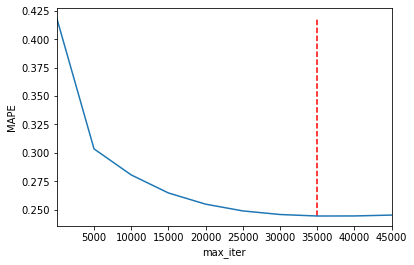

In [78]:
pd.Series(iter_score).plot()
plt.vlines(iter_score.nsmallest(1).index[0], iter_score.min(), iter_score.max(), 'r', '--')
plt.ylabel('MAPE')
plt.xlabel('max_iter')
print(iter_score.nsmallest(1))

In [79]:
lr_my = MyLinearRegression(max_iter=35000, alpha=1e-11)
lr_my.fit(X_train, y_train)
y_pred_train_my = lr_my.predict(X_train)
y_pred_my = lr_my.predict(X_test)

In [80]:
for error in [mean_absolute_error, mean_absolute_percentage_error]:
    print(error.__name__)
    print('train - %.3f, test - %.3f\n' % (error(y_train, y_pred_train_my), error(y_test, y_pred_my)))

mean_absolute_error
train - 122457.656, test - 127079.069

mean_absolute_percentage_error
train - 0.245, test - 0.244



## Logistic regression. The target column is "premium"

### Scikit-learn implementation of Logistic Regression

In [81]:
df_corr = df.corr(method='pearson')
fig = go.Figure(data=go.Heatmap(
    z=df_corr,
    x=df_corr.index.tolist(),
    y=df_corr.columns.tolist(),
    colorscale='RdBu', reversescale=True,
    zmin=-1, zmax=1, zauto=False,
    
    
))
fig.update_layout(
    title='Correlogram (Pearson)',
    width=900,
    height=900,
)
fig.show()
# fig, ax = plt.subplots(figsize=(15,10))
# sns.heatmap(df_corr, vmin=-1, vmax=1, cmap='seismic', annot=False, ax = ax);

In [82]:
df.premium.value_counts() / df.shape[0]

0    0.924301
1    0.075699
Name: premium, dtype: float64

In [83]:
use_cols = [
    'price',
    'bedrooms',
    'bathrooms',
    'sqft_living',
#     'sqft_lot', - low correlation with "premium"
    'floors',
#     'waterfront', - low correlation with "premium"
    'view',
    'condition',
    'sqft_above',
#     'sqft_basement', - low correlation with "premium"
#     'yr_built', - low correlation with "premium"
#     'yr_renovated', - is_renovated is used
    'zipcode',
#     'lat', - low correlation with "premium"
#     'long', - low correlation with "premium"
    'sqft_living15',
#     'sqft_lot15', - low correlation with "premium"
#     'month', - not related
#     'bed_bath_rooms', - 'bedrooms' and 'bathrooms' are used
#     'has_basement', - low correlation with "premium"
#     'sqft_house', - sqft_living and sqft_above are used
    'is_renovated',
#     'sqft_living_ratio', sqft_living and sqft_living15 are used
#     'sqft_lot_ratio' - low correlation with "premium"

#     #### Geo Data ####
#     'bounds_east', 'bounds_north','bounds_south','bounds_west', - low correlation with premium
#     'housing_units','land_area_in_sqmi', - low correlation with premium 
#     'major_city', - zipcode is used
#     'median_home_value','median_household_income', - high correlation with 'price'
#     'occupied_housing_units','population','population_density', - low correlation with premium 
#     'post_office_city', - zipcode is used
#     'radius_in_miles','water_area_in_sqmi', - low correlation with premium 

]

In [84]:
X = pd.get_dummies(df[use_cols], columns=[
#     'month', 
    'zipcode',
#     'condition',
#     'floors', 
#     'view', 
#     'major_city',
#     'post_office_city'
], drop_first=True)
y = df['premium']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.2, random_state=42)

In [86]:
st_scaler = StandardScaler()
num_cols = X_train.select_dtypes(np.number).columns.tolist()
X_train[num_cols] = st_scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = st_scaler.transform(X_test[num_cols])

In [87]:
logr_params = {
    'solver': 'liblinear',
    'penalty': 'l1',
    'C':10,
}

logr = LogisticRegression(**logr_params)
logr.fit(X_train, y_train)
y_prob_train = logr.predict_proba(X_train)[:,1]
y_prob = logr.predict_proba(X_test)[:,1]

Find best cut-off point for probability using f1_score

In [88]:
fbeta_thresh = {}
for thresh in range(1,100):
    thresh /= 100.0
    y_pred_train = np.where(y_prob_train >= thresh, 1, 0)
    fbeta_thresh[thresh] = f1_score(y_train, y_pred_train)
fbeta_thresh = pd.Series(fbeta_thresh)

0.31    0.733579
dtype: float64


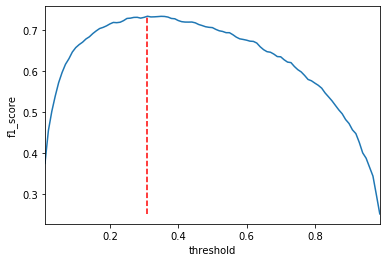

In [89]:
pd.Series(fbeta_thresh).plot()
plt.vlines(fbeta_thresh.nlargest(1).index[0], fbeta_thresh.min(), fbeta_thresh.max(), 'r', '--')
plt.xlabel('threshold')
plt.ylabel('f1_score')
print(fbeta_thresh.nlargest(1))

In [90]:
thresh = fbeta_thresh.nlargest(1).index[0]
thresh

0.31

Calculate score with cut-off found above

In [91]:
y_pred = np.where(y_prob >= thresh, 1, 0)
y_pred_train = np.where(y_prob_train >= thresh, 1, 0)

for metric in [precision_score, recall_score, f1_score]:
    print(metric.__name__)
    print('train - %.3f, test - %.3f\n' % (metric(y_train, y_pred_train), metric(y_test, y_pred)))

precision_score
train - 0.703, test - 0.706

recall_score
train - 0.767, test - 0.762

f1_score
train - 0.734, test - 0.733



In [92]:
def display_conf_matrix(y_true, y_pred):
    display(pd.DataFrame(
        confusion_matrix(y_true, y_pred), 
        columns = np.unique(y_true),
        index = np.unique(y_true)
    ).rename_axis("↓ relevant", axis=0).rename_axis("selected →", axis=1))

In [93]:
print("Train confusion matrix")
display_conf_matrix(y_train, y_pred_train)

print("\n\nTest confusion matrix")
display_conf_matrix(y_test, y_pred)

Train confusion matrix


selected →      0    1
↓ relevant            
0           15573  420
1             302  994



Test confusion matrix


selected →     0    1
↓ relevant           
0           3875  108
1             81  259

### My implementation of Logistic Regression

In [94]:
class MyLogisticRegression():
    def __init__(self, max_iter=10000, alpha=0.001, to_scale=True):
        self.max_iter = max_iter
        self.alpha = alpha
        self.to_scale = to_scale
    
    def __calculate_cost(self):
        assert(np.isin(self.y, [0,1]).all())
        
        self.J = (-1/self.m)*(np.sum((self.y*np.log(self.h)) + ((1-self.y)*(np.log(1-self.h)))))
        
    def __calculate_theta(self):
#         for j, _ in enumerate(self.theta):
#             self.theta[j] = self.theta[j] \
#             - (self.alpha / self.m) * np.sum(np.dot((self.h - self.y), self.X[:,j].T))
        self.theta = self.theta-(self.alpha/self.m)*(self.X.T.dot(self.h-self.y))
 
    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)
        
        # insert intercept
        self.X = np.insert(self.X, obj = 0, values = 1, axis=1)
        
        # scale
        if self.to_scale:
            self.st_scaler=StandardScaler()
            self.X = self.st_scaler.fit_transform(self.X)
        
        self.m = self.X.shape[0]
        self.n = self.X.shape[1]
        
        np.random.seed(42)
        self.theta=np.random.rand(self.n)
        self.J = 1e100
        t = np.matmul(self.X, self.theta)
        self.h = np.divide(1.,(1. + np.exp(-t)))
        for _ in range(self.max_iter):
#             print(self.h)
            self.__calculate_cost()
            self.__calculate_theta()
            t = np.matmul(self.X, self.theta)
            self.h = 1 / (1 + np.exp(-t))
                       
        
    def predict(self, X_test):
        self.X_test = np.array(X_test)
        self.X_test = np.insert(self.X_test, obj = 0, values = 1, axis=1)
        
        if self.to_scale:
            self.X_test = self.st_scaler.transform(self.X_test)
        t = np.matmul(self.X_test, self.theta)
        return 1 / (1 + np.exp(-t))

Find best parameters (number of iterations and alpha)

In [95]:
iter_score = {}
for num_iter in range(1, 1000, 50):
    logr_my = MyLogisticRegression(max_iter=num_iter, alpha=0.8, to_scale=False)
    logr_my.fit(X_train, y_train)
    
    y_prob_train = logr_my.predict(X_train)
    y_prob = logr_my.predict(X_test)
    
    y_pred_train_my = np.where(y_prob_train >= thresh, 1, 0)
    y_pred_my = np.where(y_prob >= thresh, 1, 0)

    iter_score[num_iter] = f1_score(y_test, y_pred_my)
iter_score = pd.Series(iter_score)

/home/daryna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

divide by zero encountered in log

/home/daryna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

invalid value encountered in multiply



551    0.732673
dtype: float64


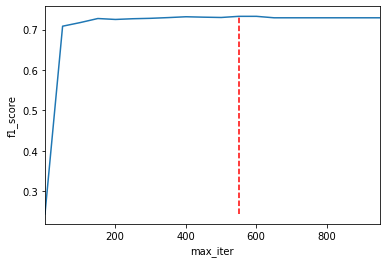

In [96]:
iter_score.plot()
plt.vlines(iter_score.nlargest(1).index[0], iter_score.min(), iter_score.max(), 'r', '--')
plt.ylabel('f1_score')
plt.xlabel('max_iter')
print(iter_score.nlargest(1))

In [97]:
logr_my = MyLogisticRegression(max_iter=551, alpha=0.8, to_scale=False)
logr_my.fit(X_train, y_train)
y_prob_train_my = logr_my.predict(X_train)
y_prob_my = logr_my.predict(X_test)

/home/daryna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

divide by zero encountered in log

/home/daryna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

invalid value encountered in multiply



In [98]:
y_pred_my = np.where(y_prob_my >= thresh, 1, 0)
y_pred_train_my = np.where(y_prob_train_my >= thresh, 1, 0)

for metric in [precision_score, recall_score, f1_score]:
    print(metric.__name__)
    print('train - %.3f, test - %.3f\n' % (metric(y_train, y_pred_train_my), metric(y_test, y_pred_my)))

precision_score
train - 0.698, test - 0.706

recall_score
train - 0.771, test - 0.762

f1_score
train - 0.733, test - 0.733



In [99]:
print("Train confusion matrix")
display_conf_matrix(y_train, y_pred_train_my)

print("\n\nTest confusion matrix")
display_conf_matrix(y_test, y_pred_my)

Train confusion matrix


selected →      0    1
↓ relevant            
0           15561  432
1             297  999



Test confusion matrix


selected →     0    1
↓ relevant           
0           3875  108
1             81  259